In [26]:
from math import sqrt, pi, log, exp
import spnhelp
import matplotlib.pyplot as plt
import scipy.stats as stats
from spn.algorithms.Inference import likelihood
import numpy as np

def integrate_log_normal(mean : float, sd : float, a : float, b : float) -> float:
    t1 = a ** 2
    t5 = sd ** 2
    t6 = log(2)
    t9 = log(pi)
    t12 = log(sd)
    t15 = b ** 2
    t18 = mean ** 2
    return 0.1e1 / t5 * (a - b) * (t1 + (-3 * mean + b) * a + 3 * t6 * t5 + 3 * t9 * t5 + 6 * t12 * t5 + t15 - 3 * b * mean + 3 * t18) / 6

def integrate_log_normal_slope(a, b, w, s): # standard normal
    t1 = a - b
    t2 = t1 ** 2
    t3 = s * t2
    t4 = 2 + t3
    t5 = t4 ** 2
    t7 = 0.1e1 / t1
    t9 = log(-t7 * t4 * w + 1e-10)
    t12 = -2 + t3
    t13 = t12 ** 2
    t16 = log(t7 * t12 * w + 1e-10)
    t23 = a ** 2
    t25 = exp(-t23 / 2)
    t26 = log(t25 + 1e-10)
    t33 = b ** 2
    t35 = exp(-t33 / 2)
    t36 = log(t35 + 1e-10)
    t39 = log(pi)
    t41 = log(2)
    t43 = t23 ** 2
    t50 = t33 ** 2
    return -1 / s / t2 * (-3 * t9 * t5 + 3 * t16 * t13 + s * t1 * (12 * t26 * a * (t1 * s * b + 2) - 12 * t36 * (t1 * s * a + 2) * b + (-12 * t39 + 12 * t41 + s * (4 * b * t23 * a - 4 * t33 * b * a + t43 - t50) + 8 * t23 + 8 * a * b + 8 * t33 + 12) * t1)) * w / 24



In [27]:
x= np.linspace(-4,4, 1000)

mu = 0
sd = 1
eps = 0.01


def kl (s, mid, e, w, mu, sd):
    kl = 0
    for i in range(len(s)):
        kl += w[i] * (log(w[i]/(e[i]-s[i])) - integrate_log_normal(mu, sd, s[i], e[i]) / (e[i] - s[i]))
    return np.array(kl)


def kl_slope (s, mid, e, w, slope):
    kl = 0
    for i in range(len(s)):
        if w[i] > 0:
            max_abs_of_slope = 1/(0.5*(e[i]-s[i])**2)
            clamped_slope = min(max(slope[i], -max_abs_of_slope), max_abs_of_slope)
            kl += integrate_log_normal_slope(s[i], e[i], w[i], clamped_slope)
    return np.array(kl)

In [28]:
splits = []
splits.append((zip(*spnhelp.gauss_discretization_params(mu, sd, 1.05, spnhelp.CRIT_uniform_bounded_ratio)), "bounded likelihood deviation"))
splits.append((zip(*spnhelp.gauss_discretization_params(mu, sd, 0.05, spnhelp.CRIT_uniform_bounded_deviation)), "bounded log-likelihood deviation"))
splits.append((zip(*spnhelp.gauss_discretization_params(mu, sd, 0.2, spnhelp.CRIT_bounded_width)), "uniform width"))

for (start, _, end, weight, slope), name in splits:
    kl_ =  kl(start, 0, end, weight, mu, sd)
    kl__ = kl_slope(start, 0, end, weight, slope)
    n = len(start)
    print("kl      :", f"{(kl_):.5f}", n, "with components for", name)
    print("kl_slope:", f"{(kl__):.5f}", n, "with components for ", name)

kl      : 0.00118 166 with components for bounded likelihood deviation
kl_slope: 0.00100 166 with components for  bounded likelihood deviation
kl      : 0.02088 14 with components for bounded log-likelihood deviation
kl_slope: 0.00283 14 with components for  bounded log-likelihood deviation
kl      : 0.00192 50 with components for uniform width
kl_slope: 0.00100 50 with components for  uniform width


Text(0.5, 0, 'eps')

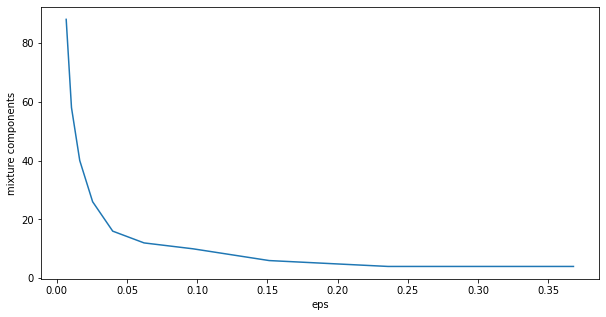

In [29]:
xs = np.exp(np.linspace(-5, -1, 10))
# plt.scatter(xs, epses)
plt.plot(xs, [len(spnhelp.gauss_discretization_params(mu, sd, e, spnhelp.CRIT_uniform_bounded_deviation)) for e in xs])
plt.ylabel("mixture components")
plt.xlabel("eps")

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]


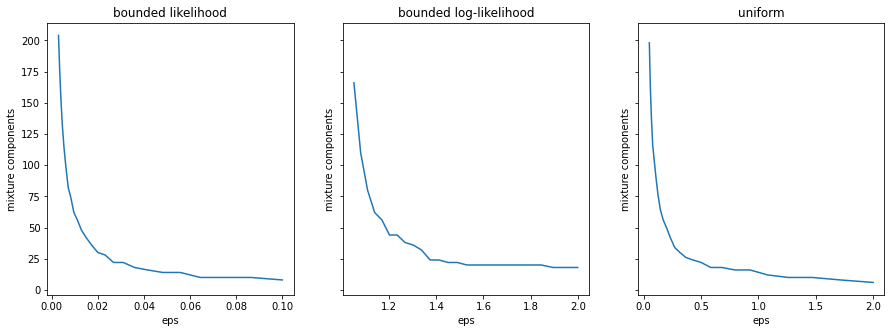

In [30]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15,5))

names = ["bounded deviation", "bounded ratio", "uniform"]
splits = []
splits.append((lambda e: spnhelp.gauss_discretization_params(mu, sd, e, spnhelp.CRIT_uniform_bounded_deviation), np.log(0.003), np.log(0.1)))
splits.append((lambda e: spnhelp.gauss_discretization_params(mu, sd, e, spnhelp.CRIT_uniform_bounded_ratio), np.log(1.05), np.log(2)))
splits.append((lambda e: spnhelp.gauss_discretization_params(mu, sd, e, spnhelp.CRIT_bounded_width), np.log(0.05), np.log(2.0)))

test_components = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250]
# test_components = [10, 20, 100]
print(test_components)
kls_uniform = [[] for s in splits]
kls_slopyform = [[] for s in splits]

for i, (f, e_min, e_max) in enumerate(splits):
    name = names[i]
    xs = np.exp(np.linspace(e_min, e_max, 25))
    ys = np.array([len(f(e)) for e in xs])
    
    for t in test_components:
        x = xs[np.argmin(np.abs(ys - t))]
        start, _, end, weight, slope = zip(*f(x))
        kl_ = kl(start, _, end, weight, mu, sd)
        kl__ = kl_slope(start, _, end, weight, slope)
        
        n = len(start)
        kls_uniform[i].append((kl_, n))
        kls_slopyform[i].append((kl__, n))
        
    ax[i].plot(xs, ys)
    ax[i].set_ylabel("mixture components")
    ax[i].set_xlabel("eps")
    ax[i].set_title(name)


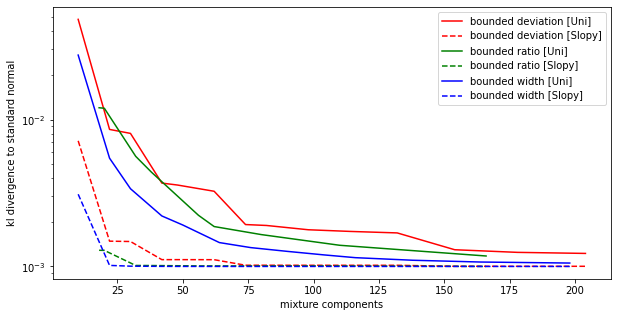

In [37]:
plt.rcParams["figure.figsize"] = (10, 5)
names = ["bounded deviation", "bounded ratio", "bounded width"]

colors = ["r", "g", "b"]
for unif_run, slopy_run, name, color in zip(kls_uniform, kls_slopyform, names, colors):
    kl_, n = zip(*unif_run)
    kl__, _ = zip(*slopy_run)
    plt.plot(n, kl_, label = name + " [Uni]", c=color)
    plt.plot(n, kl__, label = name + " [Slopy]", c=color, linestyle="dashed")

plt.xlabel("mixture components")
plt.ylabel("kl divergence to standard normal")
plt.yscale("log")
plt.legend();